In [1]:
import os.path
import scipy.io
import pandas as pd
import numpy as np
import re
import glob


In [2]:
Xsim = np.array([[  2.83717594235889647436,  11.63646180704327015576],
 [ -3.327921891190484871,    10.87319571410462337724],
 [  5.6266615323741531185,    9.06645711159280409674],
 [  6.43838210179274383904,  13.62895274146651303226],
 [ -0.73235675340731809513,   7.0584172849290567342 ],
 [ 10.95457732821499341469,  20.9159290909855073437 ],
 [ 10.94582100826051629383,   9.31802058456702120282],
 [  4.81183361703341194726,  10.56965656760404748127]])

In [3]:
# Do PCA analysis
mu = np.mean(Xsim,axis=0) # calculate mean
w,v = np.linalg.eig(np.dot((Xsim-mu).T,(Xsim-mu))) # calculate eigenvalues of covariance matrix

In [4]:
print(np.dot(Xsim-mu,v))

[[-1.51866902  1.06885836]
 [-7.00440235  3.98394604]
 [-0.71056235 -2.63696376]
 [ 2.57378213  0.6323386 ]
 [-7.06980803 -0.6296442 ]
 [10.45543239  4.00511681]
 [ 3.78876869 -5.48525481]
 [-0.51454146 -0.93839703]]


In [5]:
v[:,0] # first pca eigenvector

array([0.81871654, 0.5741979 ])

In [6]:
scores = np.dot((Xsim - mu),v[:,0]) # project into lower dimensional space
Xproj = np.outer(scores,v[:,0]) + mu # back project into original data space

In [7]:
Xproj

array([[ 3.45091217, 10.76136979],
       [-1.04034842,  7.61147321],
       [ 4.11252247, 11.22538295],
       [ 6.8014696 , 13.11124667],
       [-1.09389714,  7.57391741],
       [13.25430701, 17.63687373],
       [ 7.79619919, 13.80888941],
       [ 4.27300801, 11.33793773]])

Text(0.5, 1.0, 'PCA dimensionality reduction')

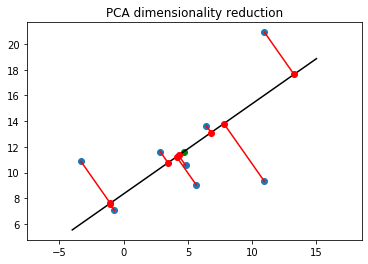

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(Xsim[:,0],Xsim[:,1],'o')
plt.plot(mu[0],mu[1],'go')
x = np.linspace(-4,15)
y = v[1,0]/v[0,0] * (x - mu[0]) + mu[1]
plt.plot(x,y,'k')

plt.plot(Xproj[:,0], Xproj[:,1], 'ro')
for x, y in zip(Xsim, Xproj):
    plt.plot([x[0],y[0]], [x[1],y[1]], 'r-')
    
plt.axis('equal')
plt.title('PCA dimensionality reduction')

### Latent variable model of Dimensionality Reduction (P-PCA)

 - Latent variable $\mathbf{z} \in \mathcal{R}^M \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
 - Data $\mathbf{x} \in \mathcal{R}^D = W \mathbf{x} + \mu + \epsilon$, where $\epsilon \sim 
     \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I})$.
 - Model parameters are $W \sim M \times D$ and $\sigma^2$
     

### _A posteriori_ distribution of latent variable

$$
\begin{align}
\Pr(\mathbf{z} \mid \mathbf{x}) &= \mathcal{N}( E[\mathbf{z}], \mathrm{Cov}(\mathbf{z})) \\
&= \mathcal{N}(W^T C^{-1} (\mathbf{x} - \mu), \mathbf{I} - W^T C^{-1} W)
\end{align}$$
where $C = W W^T + \sigma^2 \mathbf{I}$ is the covariance of the marginal $\Pr(x)$.

### EM algorithm for P-PCA
 1. Initialize parameters
 2. **E-step:** Calculate $\Pr(\mathbf{z}_n \mid \mathbf{x}_n)$ for each data point. You will need the mean of this
 distribution, $E[\mathbf{z}_n]$ and the outer product 
 $E[\mathbf{z}_n \, \mathbf{z}_n^T] = \mathrm{Cov}(\mathbf{z}_n) + 
     E[\mathbf{z}_n] E[\mathbf{z}_n]^T$
 3. **M-step:** Update $W$ and $\sigma^2$
 
     $$W_{new} = \left( \sum_{n=1}^N (\mathbf{x}-\mu) \; E[\mathbf{z}_n]^T \right) 
     \left(\sum_{n=1}^N E[\mathbf{z} \, \mathbf{z}^T] \right)^{-1}$$
     
     $$\sigma_{new}^2 = \frac{1}{N D} \mathrm{Tr} \left( \sum_{n=1}^N (\mathbf{x}-\mu) (\mathbf{x}-\mu)^T -
     W_{new} \sum_{n=1}^N E[\mathbf{z}_n] (\mathbf{x}-\mu)^T \right)$$
     
 4. Iterate until convergence (or just a bunch of times)

In [9]:
D = Xsim.shape[1]
N = Xsim.shape[0]
M = 1
# EM for P-PCA

# Initialize parameters
Wnew = np.random.randn(D,1)
sigNew = 0.5

# Note that differently from our normal convention, Xsim is an NxD matrix.
# That means each observation is a row vector rather than a column vector.
# The result is that Ez ends up being a row vector (EzzT is properly square).
for i in range(5000):
    Wold = Wnew
    sigOld = sigNew
    C = Wold.dot(Wold.T) + sigOld*np.eye(D) # covariance of P(x)
    Ez = Wold.T.dot(np.linalg.inv(C)).dot((Xsim - mu).T) # W^T C^-1 (x - mu)
    EzzT = (np.eye(M) - Wold.T.dot(np.linalg.inv(C)).dot(Wold))*N + (Ez.dot(Ez.T)) # Cov(z) + Ez Ez^T
    Wnew = ((Xsim - mu).T).dot(Ez.T) # break it into two lines - first product of (x-mu) and Ez
    Wnew = Wnew.dot(np.linalg.inv(EzzT)) # then scale down by EzzT
    sigNew = 1/(N*D) * np.trace((Xsim - mu).T.dot(Xsim-mu) - Wnew.dot(Ez.dot(Xsim-mu))) # Note that the transposes 
                                                    # are in the opposite order than above because of dims of Xsim
    

In [10]:
# Now, we want to compare PPCA dimensions to PCA dimensions
u1,s1,v1 = np.linalg.svd(Wnew)
u1[:,0]

array([0.81871654, 0.5741979 ])

In [11]:
C = Wnew.dot(Wnew.T) + sigNew*np.eye(D)
z_ppca = Wnew.T.dot(np.linalg.inv(C)).dot((Xsim - mu).T)
Xproj_ppca = (Wnew.dot(z_ppca)).T + mu

Text(0.5, 1.0, 'P-PCA')

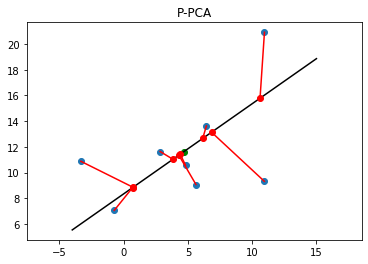

In [12]:
plt.plot(Xsim[:,0],Xsim[:,1],'o')
plt.plot(mu[0],mu[1],'go')
x = np.linspace(-4,15)
y = Wnew[1]/Wnew[0] * (x - mu[0]) + mu[1]
plt.plot(x,y,'k')

plt.plot(Xproj_ppca[:,0], Xproj_ppca[:,1], 'ro')
for x, y in zip(Xsim, Xproj_ppca):
    plt.plot([x[0],y[0]], [x[1],y[1]], 'r-')
    
plt.axis('equal')
plt.title('P-PCA')


### Latent variable model of Dimensionality Reduction (Factor Analysis)

 - Latent variable $\mathbf{z} \in \mathcal{R}^M \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
 - Data $\mathbf{x} \in \mathcal{R}^D = W \mathbf{x} + \mu + \epsilon$, where $\epsilon \sim 
     \mathcal{N}(\mathbf{0}, \Psi)$.
 - Model parameters are $W \sim M \times D$ and $\Psi$
     
The difference between P-PCA and FA is that in FA, the observation noise is a diagonal matrix, $\Psi$, rather
than a diagonal matrix with constant value, $\sigma^2 \mathbf{I}$.

### _A posteriori_ distribution of latent variable

$$
\begin{align}
\Pr(\mathbf{z} \mid \mathbf{x}) &= \mathcal{N}( E[\mathbf{z}], \mathrm{Cov}(\mathbf{z})) \\
&= \mathcal{N}(W^T C^{-1} (\mathbf{x} - \mu), \mathbf{I} - W^T C^{-1} W)
\end{align}$$
where $C = W W^T + \Psi$ is the covariance of the marginal $\Pr(x)$. **(Note that this is different than P-PCA!)**

### EM algorithm for P-PCA
 1. Initialize parameters
 2. **E-step:** Calculate $\Pr(\mathbf{z}_n \mid \mathbf{x}_n)$ for each data point. You will need the mean of this
 distribution, $E[\mathbf{z}_n]$ and the outer product 
 $E[\mathbf{z}_n \, \mathbf{z}_n^T] = \mathrm{Cov}(\mathbf{z}_n) + 
     E[\mathbf{z}_n] E[\mathbf{z}_n]^T$
 3. **M-step:** Update $W$ and $\sigma^2$
 
     $$W_{new} = \left( \sum_{n=1}^N (\mathbf{x}-\mu) \; E[\mathbf{z}_n]^T \right) 
     \left(\sum_{n=1}^N E[\mathbf{z} \, \mathbf{z}^T] \right)^{-1}$$
     
     $$\Psi_{new} = \frac{1}{N} \mathrm{diag} \left( \sum_{n=1}^N (\mathbf{x}-\mu) (\mathbf{x}-\mu)^T -
     W_{new} \sum_{n=1}^N E[\mathbf{z}_n] (\mathbf{x}-\mu)^T \right)$$
     
     where "$\mathrm{diag}()$" means to zero the off-diagonal elements.
     
 4. Iterate until convergence (or just a bunch of times)